In [11]:
import random
import math
from alive_progress import alive_bar #progress bar for loops
import matplotlib.pyplot as plt
import numpy as np
import time
import heapq #min-heap priority queue
import gc

# PART A

Suppose the input graph G = (V, E) is stored in an adjacency matrix and we
use an array for the priority queue. Implement the Dijkstra’s algorithm using this
setting and analyze its time complexity with respect to |V| and |E| both
theoretically and empirically.


Generating matrix for V=10 at density=0.7 ...
V=10 → runtime: 0.0021 s, comparisons: 34

Generating matrix for V=50 at density=0.7 ...
V=50 → runtime: 0.0008 s, comparisons: 863

Generating matrix for V=100 at density=0.7 ...
V=100 → runtime: 0.0045 s, comparisons: 3495

Generating matrix for V=200 at density=0.7 ...
V=200 → runtime: 0.0752 s, comparisons: 13790

Generating matrix for V=500 at density=0.7 ...
V=500 → runtime: 0.1416 s, comparisons: 87224

Generating matrix for V=1000 at density=0.7 ...
V=1000 → runtime: 0.5835 s, comparisons: 350175

Generating matrix for V=2000 at density=0.7 ...
V=2000 → runtime: 0.8007 s, comparisons: 1399499

Generating matrix for V=5000 at density=0.7 ...
V=5000 → runtime: 14.7741 s, comparisons: 8749723

Generating matrix for V=10000 at density=0.7 ...
V=10000 → runtime: 51.7014 s, comparisons: 35000295

Generating matrix for V=20000 at density=0.7 ...
V=20000 → runtime: 212.8243 s, comparisons: 140000720


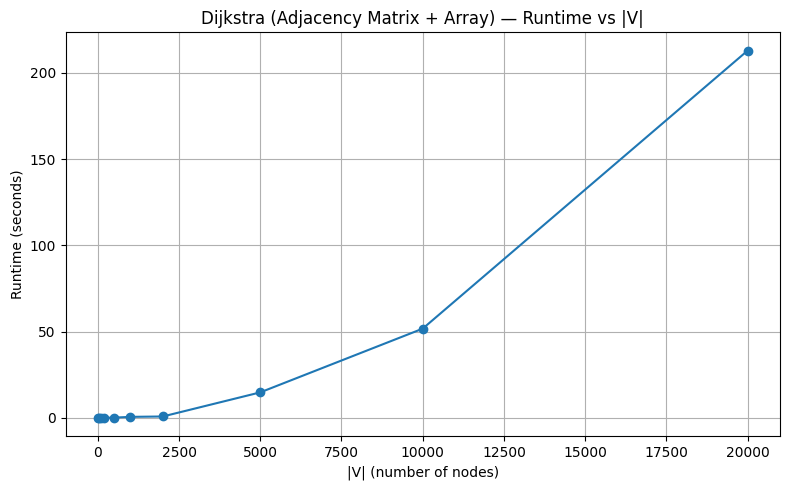


=== Part A Results Table ===
V=    10  Runtime=0.002130 s  Comparisons=34
V=    50  Runtime=0.000829 s  Comparisons=863
V=   100  Runtime=0.004547 s  Comparisons=3495
V=   200  Runtime=0.075165 s  Comparisons=13790
V=   500  Runtime=0.141617 s  Comparisons=87224
V=  1000  Runtime=0.583466 s  Comparisons=350175
V=  2000  Runtime=0.800715 s  Comparisons=1399499
V=  5000  Runtime=14.774052 s  Comparisons=8749723
V= 10000  Runtime=51.701432 s  Comparisons=35000295
V= 20000  Runtime=212.824324 s  Comparisons=140000720


In [ ]:
# PART A

# config
v_sizes = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
density = 0.7
trials_per_size = 1
rng_seed = 42
np.random.seed(rng_seed)
random.seed(rng_seed)

# -------------------------
# Adjacency Matrix Generator (dense-ish; Θ(V^2) space)
# Uses float32 to reduce RAM footprint.
# -------------------------
def generate_adj_matrix(V, density=0.7):
    INF = np.inf
    # start with all INF
    mat = np.full((V, V), INF, dtype=np.float32)

    # randomly add edges based on density
    mask = np.random.rand(V, V) < density
    np.fill_diagonal(mask, False)

    # assign random weights
    weights = np.random.randint(1, 11, size=(V, V)).astype(np.float32)
    mat[mask] = weights[mask]

    # zero diagonal
    np.fill_diagonal(mat, 0.0)
    return mat

# dijkstra with adjacency matrix and array-based priority queue
def dijkstra(V, E, start):
    INF = float('inf')
    d  = {node: INF for node in V}
    pi = {node: None for node in V}
    d[start] = 0.0
    Q = set()
    
    comparisons = 0

    while len(Q) < len(V):
        # find unvisited node with min distance
        u = min((node for node in V if node not in Q), key=lambda node: d[node])
        Q.add(u)

        # check all adjacent nodes
        row = E[u]
        for v in V:
            if v not in Q and not math.isinf(row[v]):
                comparisons += 1
                alt = d[u] + float(row[v])
                if alt < d[v]:
                    d[v] = alt
                    pi[v] = u
    return d, pi, comparisons

# run tests
results = []
for n in v_sizes:
    # quick RAM sanity check (rough lower bound)
    # float32 matrix needs ~4 * n^2 bytes
    approx_bytes = 4 * (n**2)
    approx_gb = approx_bytes / (1024**3)
    if approx_gb > 1.6:
        print(f"Skipping V={n} (≈{approx_gb:.2f} GB) to avoid OOM.")
        results.append((n, None, None))
        continue

    try:
        print(f"\nGenerating matrix for V={n} at density={density} ...")
        A = generate_adj_matrix(n, density=density)

        times = []
        comps_list = []
        for t in range(trials_per_size):
            start_node = 0
            V = range(n)

            t0 = time.perf_counter()
            d, pi, comps = dijkstra(V, A, start_node)
            t1 = time.perf_counter()

            times.append(t1 - t0)
            comps_list.append(comps)
            gc.collect()

        avg_time = sum(times) / len(times)
        avg_comps = sum(comps_list) / len(comps_list)
        results.append((n, avg_time, avg_comps))
        print(f"V={n} → runtime: {avg_time:.4f} s, comparisons: {avg_comps:.0f}")

        del A
        gc.collect()

    except MemoryError:
        print(f"MemoryError at V={n}. Skipping.")
        results.append((n, None, None))
        gc.collect()

# plot results
sizes = [n for n, t, c in results if t is not None]
times = [t for n, t, c in results if t is not None]
comparisons = [c for n, t, c in results if c is not None]

# -------------------------
# Plot: |V| vs Runtime
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(sizes, times, marker='o')
plt.xlabel('|V| (number of nodes)')
plt.ylabel('Runtime (seconds)')
plt.title('Dijkstra (Adjacency Matrix + Array) — Runtime vs |V|')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# Print results table
# -------------------------
print("\n=== Part A Results Table ===")
for n, t, c in results:
    if t is not None:
        print(f"V={n:>6}  Runtime={t:.6f} s  Comparisons={c:.0f}")
    else:
        print(f"V={n:>6}  Runtime=SKIPPED")

# PART B


Suppose the input graph G = (V, E) is stored in an array of adjacency lists and
we use a minimizing heap for the priority queue. Implement the Dijkstra’s
algorithm using this setting and analyze its time complexity with respect to |V|
and |E| both theoretically and empirically.

### Graph Generation

In [13]:
# Generating random graphs (array of adjacency lists)

# can use for sparse graphs
def generate_random_graph(num_graphs, V, E, max_weight=10): 
    graphs = {V[_]: [] for _ in range(len(V))} if len(V)>1 else {E[_]:[ ] for _ in range(len(E))}
    # print(graphs)
    if len(V)>1:
        keys = V
    else:
        keys = E
    for i in range(len(V)):
        for j in range(num_graphs):
            for k in range(len(E)):
                graph = [[] for _ in range(V[i])]  # adjacency list representation
                edges_added = 0
                while edges_added < E[k]:  # ensure we add exactly E edges
                    u = random.randint(0, V[i]-1)
                    v = random.randint(0, V[i]-1)
                    if u != v and all(nei[0] != v for nei in graph[u]):  # avoid duplicates & self-loop
                        w = random.randint(1, max_weight)
                        graph[u].append((v, w))
                        graph[v].append((u, w)) # undirected
                        edges_added += 1
                if len(V)>1:
                    graphs[keys[i]].append(graph)
                else:
                    graphs[keys[k]].append(graph)
    return graphs

import random

# use for dense graphs, ensures full connectivity
def generate_random_connected_graph(num_graphs, V, E, max_weight=10): 
    graphs = {V[_]: [] for _ in range(len(V))} if len(V) > 1 else {E[_]: [] for _ in range(len(E))}

    if len(V) > 1:
        keys = V
    else:
        keys = E

    for i in range(len(V)):
        for j in range(num_graphs):
            for k in range(len(E)):
                n = V[i]
                target_edges = E[k]*V[i] # total edges = avg edges per vertex * num vertices, average across the whole graph, not a strict per-vertex count
                graph = [[] for _ in range(n)]

                vertices = list(range(n))
                random.shuffle(vertices)
                for idx in range(1, n):
                    u = vertices[idx]
                    v = random.choice(vertices[:idx])
                    w = random.randint(1, max_weight)
                    graph[u].append((v, w))
                    graph[v].append((u, w))
                edges_added = n - 1

                # add extra random edges until we reach target count
                while edges_added < target_edges:
                    u = random.randint(0, n - 1)
                    v = random.randint(0, n - 1)
                    if u != v and all(nei[0] != v for nei in graph[u]):
                        w = random.randint(1, max_weight)
                        graph[u].append((v, w))
                        graph[v].append((u, w))  # undirected
                        edges_added += 1
                if len(V) > 1:
                    graphs[keys[i]].append(graph)
                else:
                    graphs[keys[k]].append(graph)
    return graphs


# fixed num_edges = 5
random.seed(2025) 
num_edges = 20 # average number of edges per vertex
vertex_size = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 27500] # number of vertices
graphs_fixed_E = generate_random_connected_graph(5, vertex_size, [num_edges]) # 5 graphs for each vertex size

# fixed num_vertices = 10000
random.seed(2025) 
num_vertices = 10000
edge_size = [2, 3, 4, 5, 6] #average number of edges per vertex
graphs_fixed_V = generate_random_connected_graph(5, [num_vertices], edge_size) 

# Sample graph
g = [
    [(1, 2), (2, 4)],          # neighbors of vertex 0 (neighbor, weight)
    [(0, 2), (2, 1)],          # neighbors of vertex 1
    [(0, 4), (1, 2), (3, 3)],  # neighbors of vertex 2
    [(2, 3)]                   # neighbors of vertex 3
]

In [14]:
def dijkstra_minheap(graph, start):
    V = len(graph)
    S = [False] * V
    d = [math.inf] * V
    pi = [None]* V
    pq = []
    heapq.heappush(pq, (0, start)) # (distance, vertex)

    d[start] = 0
    pi[start] = None
    
    comparisons = 0
    while pq:
        di, u = heapq.heappop(pq)
        if S[u]:
            continue
        else:
            for v, w in graph[u]:
                comparisons += 1
                if d[u] + w < d[v]: #found better path to v, update distance
                    d[v] = d[u] + w
                    pi[v] = u
                    heapq.heappush(pq, (d[v], v))
            S[u] = True
    
    return (d, pi, comparisons)

execution_time_fixedE = {}
execution_comparisons_fixedE = {}

for V, graphs_list in graphs_fixed_E.items():
    total = 0
    total_time = 0
    length = len(graphs_list)
    for j, graph in enumerate(graphs_list):
        # print(f"Running Dijkstra's for V={V}, graph {j+1}/{length}")
        start = time.perf_counter()
        dijkstra_minheap(graph, 0)
        end = time.perf_counter()
        total_time += end - start
        total += dijkstra_minheap(graph, 0)[2]
    execution_time_fixedE[V] = total_time / length
    execution_comparisons_fixedE[V] = total / length

execution_time_fixedV = {}
execution_comparisons_fixedV = {}

for E, graphs_list in graphs_fixed_V.items():
    total = 0
    total_time = 0
    length = len(graphs_list)
    for j, graph in enumerate(graphs_list):
        # print(f"Running Dijkstra's for E={E}, graph {j+1}/{length}")
        start = time.perf_counter()
        dijkstra_minheap(graph, 0)
        end = time.perf_counter()
        total_time += end - start
        total += dijkstra_minheap(graph, 0)[2]
    execution_time_fixedV[E*10000] = total_time / length
    execution_comparisons_fixedV[E*10000] = total / length

print("Comparisons for Varying number of vertices:", execution_time_fixedE)
print("Comparisons for Varying number of edges:", execution_time_fixedV)

Comparisons for Varying number of vertices: {2500: 0.028572100000019418, 5000: 0.06711299999951734, 7500: 0.10726464000035776, 10000: 0.13520043999888004, 12500: 0.20302951999838115, 15000: 0.2390564200009976, 17500: 0.2549812799996289, 20000: 0.33707420000064303, 25000: 0.41758265999887956, 27500: 0.49010074000034365}
Comparisons for Varying number of edges: {20000: 0.022908260000986048, 30000: 0.027540819999558153, 40000: 0.04538969999994151, 50000: 0.044315980000101264, 60000: 0.04369326000014553}


### Theoretical comparisons

In the worst case,

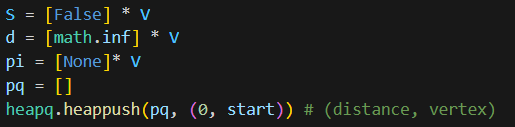<br>
 First 3 = $O(n)$ <br>
 Heap operation = $O(log \ 1)$ = $O(1)$ <br>
 Total = $O(V)$ <br>

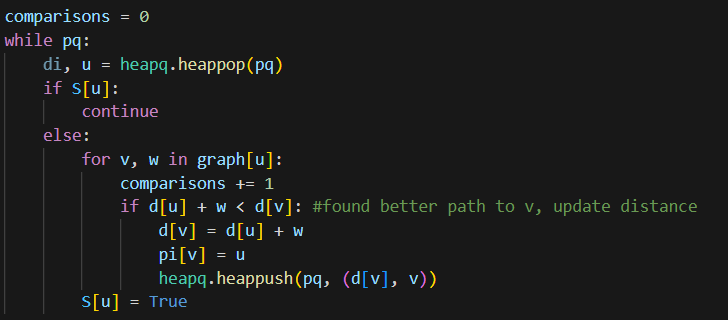<br>
Each edge is pushed into the heap once per inner loop, potentially multiple times <br>
Maximum number of heappush operations: $O(E)$ (one per edge)<br>
Maximum number of heappop operations: $O(V + E)$<br>
Each heap operation = $O(log \ V)$<br>
Heap operations: $O((V + E) \ log \  V)$<br>
Edge comparisons: $O(E)$ <br>
Initialization: $O(V)$<br>
Total: $$O((V + E) \ log \  V)$$

In [15]:
# estimating execution time of one operation
fixedE = list(execution_time_fixedE.values())
fixedE_comparisons = list(execution_comparisons_fixedE.values())
totalfixedE = 0
j = 0
for i in vertex_size:
    totalfixedE += (fixedE[j] / fixedE_comparisons[j])
    j += 1
time_per_op_fixedE = totalfixedE / len(vertex_size)

print("Estimated time per operation (fixed E):", time_per_op_fixedE)

fixedV = list(execution_time_fixedV.values())
fixedV_comparisons = list(execution_comparisons_fixedV.values())
totalfixedV = 0
j = 0
for i in edge_size:
    # print(i)
    totalfixedV += (fixedV[j] / fixedV_comparisons[j])
    j += 1
time_per_op_fixedV = totalfixedV / len(edge_size)

print("Estimated time per operation (fixed V):", time_per_op_fixedV)

def theoretical_comparisons(V, E):
    return (E + V) * math.log2(V)

theoretical_comparisons_fixedV = {S*10000: theoretical_comparisons(10000, S*10000) for S in edge_size}
theoretical_comparisons_fixedE = {S: theoretical_comparisons(S, 20*S) for S in vertex_size}   
theoretical_time_fixedV = {S*10000: theoretical_comparisons(10000, S*10000) * time_per_op_fixedV for S in edge_size}
theoretical_time_fixedE = {S: theoretical_comparisons(S, 20*S) * time_per_op_fixedV for S in vertex_size}   

Estimated time per operation (fixed E): 3.77005281536203e-07
Estimated time per operation (fixed V): 4.812723433370896e-07


### Plotting time taken against number of vertices, V (log scale)

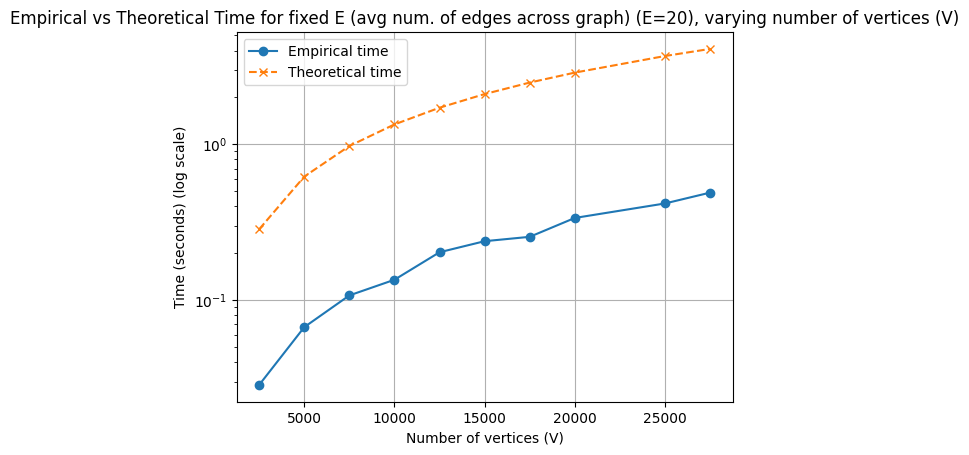

In [16]:
# plotting empirical vs theoretical results
plt.plot(list(execution_time_fixedE.keys()), list(execution_time_fixedE.values()), label="Empirical time", marker="o")
plt.plot(list(theoretical_time_fixedE.keys()), list(theoretical_time_fixedE.values()), label="Theoretical time", linestyle="--", marker="x")

plt.xlabel("Number of vertices (V)")
plt.ylabel("Time (seconds) (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Time for fixed E (avg num. of edges across graph) (E={num_edges}), varying number of vertices (V)")
plt.legend()
plt.grid(True)
plt.show()

### Plotting number of comparisons against number of vertices, V (log scale)

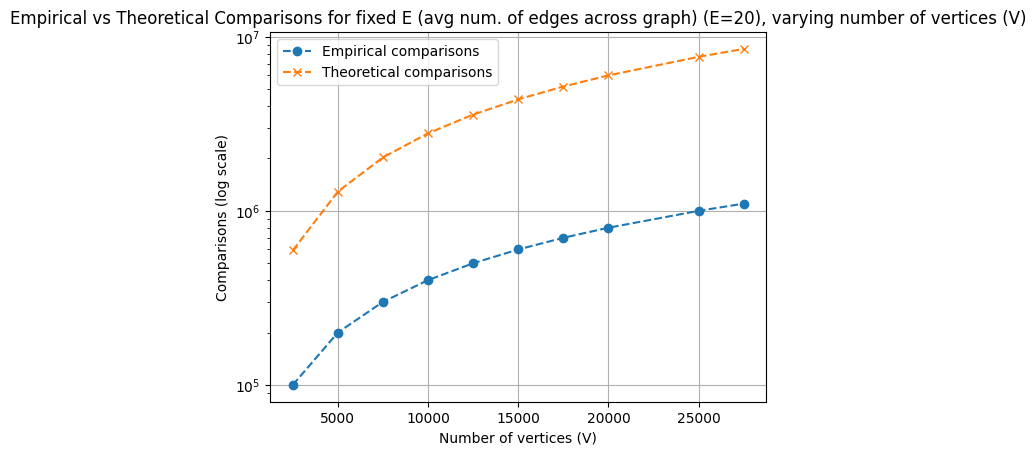

In [17]:
plt.plot(list(execution_comparisons_fixedE.keys()), list(execution_comparisons_fixedE.values()), label="Empirical comparisons", linestyle="--", marker="o")
plt.plot(list(theoretical_comparisons_fixedE.keys()), list(theoretical_comparisons_fixedE.values()), label="Theoretical comparisons", linestyle="--", marker="x")
plt.xlabel("Number of vertices (V)")
plt.ylabel("Comparisons (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Comparisons for fixed E (avg num. of edges across graph) (E={num_edges}), varying number of vertices (V)")
plt.legend()
plt.grid(True)
plt.show()

### Plotting time taken against number of edges, E*10000 (log scale)

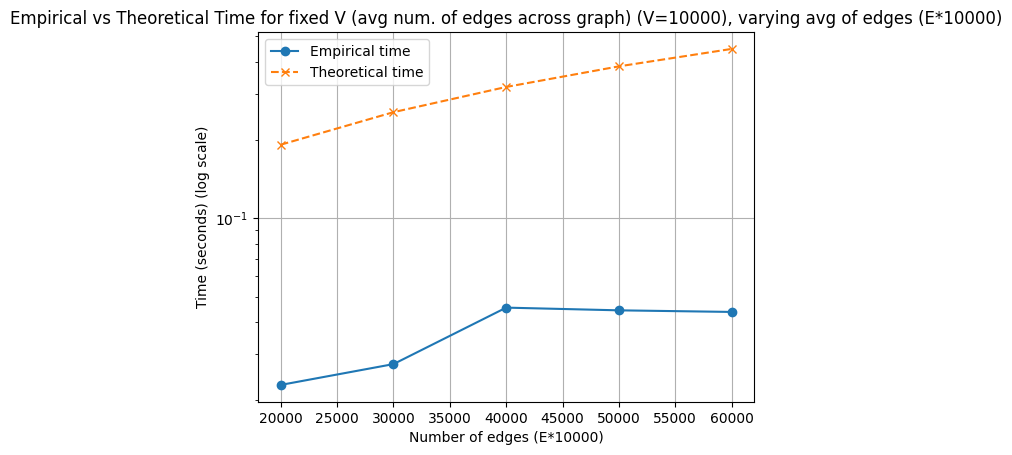

In [18]:
# plotting empirical vs theoretical results
plt.plot(list(execution_time_fixedV.keys()), list(execution_time_fixedV.values()), label="Empirical time", marker="o")
plt.plot(list(theoretical_time_fixedV.keys()), list(theoretical_time_fixedV.values()), label="Theoretical time", linestyle="--", marker="x")

plt.xlabel("Number of edges (E*10000)")
plt.ylabel("Time (seconds) (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Time for fixed V (avg num. of edges across graph) (V={num_vertices}), varying avg of edges (E*10000)")
plt.legend()
plt.grid(True)
plt.show()

### Plotting number of comparisons against number of edges, E*10000 (log scale)

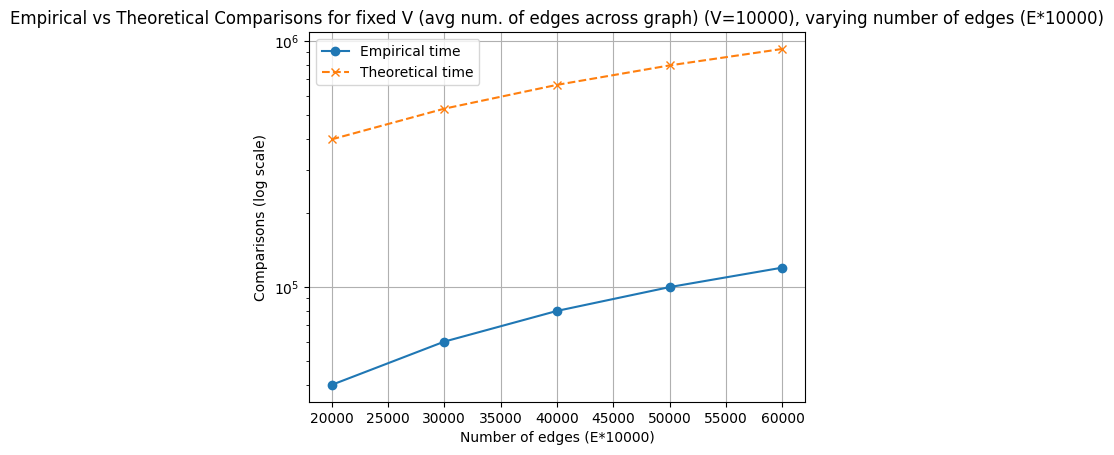

In [19]:
# plotting empirical vs theoretical results
plt.plot(list(execution_comparisons_fixedV.keys()), list(execution_comparisons_fixedV.values()), label="Empirical time", marker="o")
plt.plot(list(theoretical_comparisons_fixedV.keys()), list(theoretical_comparisons_fixedV.values()), label="Theoretical time", linestyle="--", marker="x")

plt.xlabel("Number of edges (E*10000)")
plt.ylabel("Comparisons (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Comparisons for fixed V (avg num. of edges across graph) (V={num_vertices}), varying number of edges (E*10000)")
plt.legend()
plt.grid(True)
plt.show()

### Reasons for discrepancy
Theoretical bound assumes the worst-case graph layout and maximum heap usage per edge and vertex.

In random, fully connected graphs (with high but not maximum edge counts per node), Dijkstra's algorithm empirically performs fewer relaxations, many alternative paths are quickly deemed non-optimal, and their associated heap and comparison costs are avoided.

# part c: comparison of two implementations

compare the implementations from part a and part b. discuss which implementation is better and in what circumstances.

In [ ]:
# convert adjacency matrix to adjacency list
def matrix_to_adjacency_list(matrix):
    n = len(matrix)
    adj_list = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if matrix[i][j] != math.inf and matrix[i][j] != 0:
                adj_list[i].append((j, matrix[i][j]))
    return adj_list

# test both implementations on the same graphs
random.seed(100)
np.random.seed(100)

test_sizes = [100, 500, 1000, 2000, 3000]
test_densities = {'sparse': 0.1, 'medium': 0.5, 'dense': 0.9}

results_comparison = {
    'sparse': {'part_a': {'time': {}, 'comps': {}}, 'part_b': {'time': {}, 'comps': {}}},
    'medium': {'part_a': {'time': {}, 'comps': {}}, 'part_b': {'time': {}, 'comps': {}}},
    'dense': {'part_a': {'time': {}, 'comps': {}}, 'part_b': {'time': {}, 'comps': {}}}
}

print("running part c comparison tests...")
print("=" * 60)

# test the graphs using both implementations
for density_name, density_val in test_densities.items():
    print(f"\n{density_name.upper()} graphs (density = {density_val}):")
    print("-" * 60)
    
    for v in test_sizes:
        # generate same graph for both implementations
        test_matrix = generate_adj_matrix(v, density_val)
        test_list = matrix_to_adjacency_list(test_matrix)
        
        # test part a (matrix + array)
        start_time = time.perf_counter()
        _, _, comps_a = dijkstra(range(v), test_matrix, 0)
        time_a = time.perf_counter() - start_time
        
        # test part b (list + heap)
        start_time = time.perf_counter()
        _, _, comps_b = dijkstra_minheap(test_list, 0)
        time_b = time.perf_counter() - start_time
        
        results_comparison[density_name]['part_a']['time'][v] = time_a
        results_comparison[density_name]['part_a']['comps'][v] = comps_a
        results_comparison[density_name]['part_b']['time'][v] = time_b
        results_comparison[density_name]['part_b']['comps'][v] = comps_b
        
        speedup = time_a / time_b if time_b > 0 else 0
        winner = "part b" if time_b < time_a else "part a"
        
        print(f"v={v:4} | part a: {time_a:.4f}s | part b: {time_b:.4f}s | speedup: {speedup:.2f}x ({winner})")
        
        del test_matrix, test_list
        gc.collect()

print("\n" + "=" * 60)
print("comparison complete!")

Running Part C comparison tests...

SPARSE GRAPHS (density = 0.1):
------------------------------------------------------------
V= 100 | Part A: 0.0023s | Part B: 0.0004s | Speedup: 5.27x (Part B)
V= 500 | Part A: 0.0459s | Part B: 0.0100s | Speedup: 4.58x (Part B)
V=1000 | Part A: 0.1722s | Part B: 0.0115s | Speedup: 15.02x (Part B)
V=2000 | Part A: 0.5399s | Part B: 0.0503s | Speedup: 10.73x (Part B)
V=3000 | Part A: 1.2875s | Part B: 0.1023s | Speedup: 12.59x (Part B)

MEDIUM GRAPHS (density = 0.5):
------------------------------------------------------------
V= 100 | Part A: 0.0020s | Part B: 0.0017s | Speedup: 1.17x (Part B)
V= 500 | Part A: 0.0397s | Part B: 0.0129s | Speedup: 3.08x (Part B)
V=1000 | Part A: 0.1504s | Part B: 0.0465s | Speedup: 3.23x (Part B)
V=2000 | Part A: 0.7422s | Part B: 0.1770s | Speedup: 4.19x (Part B)
V=3000 | Part A: 1.6027s | Part B: 0.4543s | Speedup: 3.53x (Part B)

DENSE GRAPHS (density = 0.9):
-------------------------------------------------------

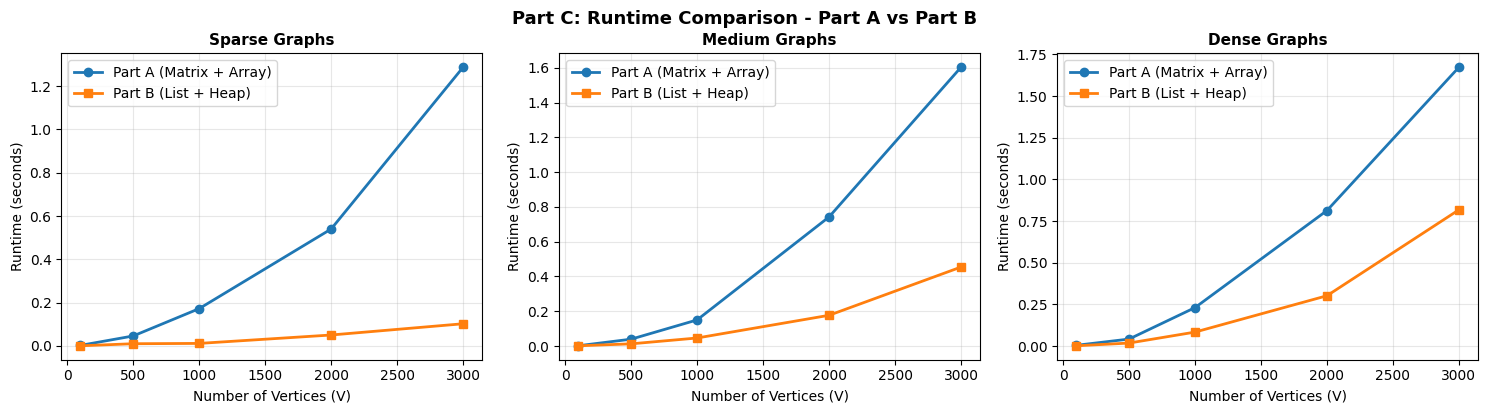

In [ ]:
# visualize runtime comparison for different graph densities
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (density_name, ax) in enumerate(zip(['sparse', 'medium', 'dense'], axes)):
    v_list = list(results_comparison[density_name]['part_a']['time'].keys())
    time_a = list(results_comparison[density_name]['part_a']['time'].values())
    time_b = list(results_comparison[density_name]['part_b']['time'].values())
    
    ax.plot(v_list, time_a, 'o-', label='part a (matrix + array)', linewidth=2, markersize=6)
    ax.plot(v_list, time_b, 's-', label='part b (list + heap)', linewidth=2, markersize=6)
    ax.set_xlabel('number of vertices (v)', fontsize=10)
    ax.set_ylabel('runtime (seconds)', fontsize=10)
    ax.set_title(f'{density_name.capitalize()} graphs', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('part c: runtime comparison - part a vs part b', fontsize=13, fontweight='bold', y=1.02)
plt.show()


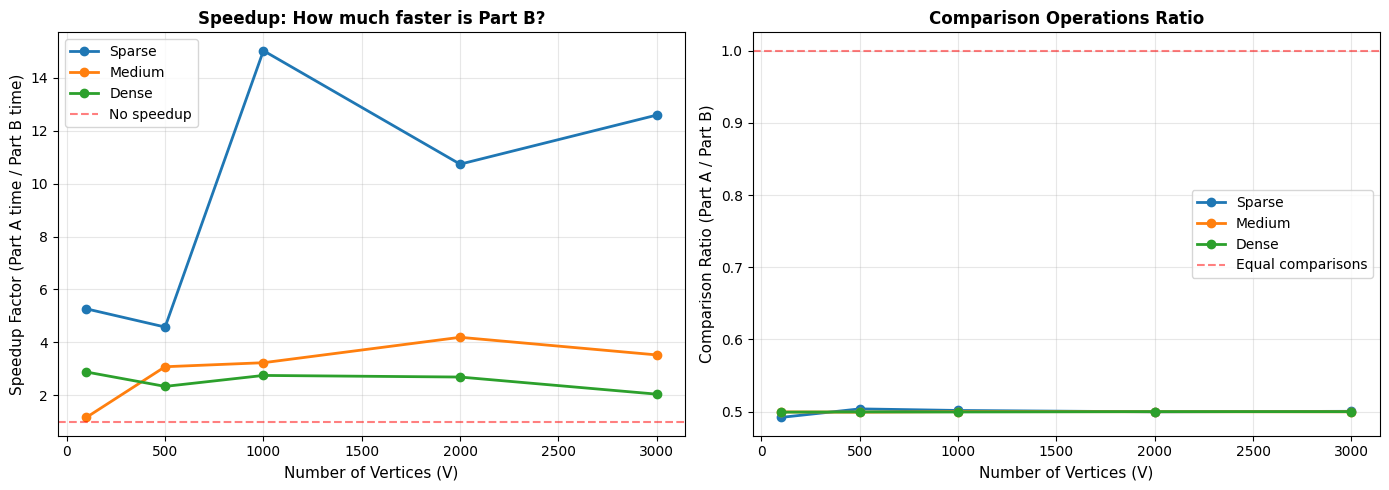

In [ ]:
# calculate and visualize speedup (how many times faster part b is than part a)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# speedup plot
for density_name in ['sparse', 'medium', 'dense']:
    v_list = list(results_comparison[density_name]['part_a']['time'].keys())
    speedups = []
    for v in v_list:
        time_a = results_comparison[density_name]['part_a']['time'][v]
        time_b = results_comparison[density_name]['part_b']['time'][v]
        speedup = time_a / time_b if time_b > 0 else 0
        speedups.append(speedup)
    
    ax1.plot(v_list, speedups, 'o-', label=f'{density_name.capitalize()}', linewidth=2, markersize=6)

ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='no speedup')
ax1.set_xlabel('number of vertices (v)', fontsize=11)
ax1.set_ylabel('speedup factor (part a time / part b time)', fontsize=11)
ax1.set_title('speedup: how much faster is part b?', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# comparison count plot
for density_name in ['sparse', 'medium', 'dense']:
    v_list = list(results_comparison[density_name]['part_a']['comps'].keys())
    comps_a = list(results_comparison[density_name]['part_a']['comps'].values())
    comps_b = list(results_comparison[density_name]['part_b']['comps'].values())
    
    # calculate ratio
    ratios = [ca / cb if cb > 0 else 0 for ca, cb in zip(comps_a, comps_b)]
    ax2.plot(v_list, ratios, 'o-', label=f'{density_name.capitalize()}', linewidth=2, markersize=6)

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='equal comparisons')
ax2.set_xlabel('number of vertices (v)', fontsize=11)
ax2.set_ylabel('comparison ratio (part a / part b)', fontsize=11)
ax2.set_title('comparison operations ratio', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## analysis

### summary of key findings

**time complexity:**
- **part a (matrix + array):** o(v²) - independent of edge count
- **part b (list + heap):** o((v + e) log v) - depends on both vertices and edges

**space complexity:**
- **part a:** o(v²) - must store entire adjacency matrix
- **part b:** o(v + e) - only stores existing edges

### which implementation is better?

the answer depends on the **graph characteristics**:

#### **part b (adjacency list + min-heap) is better when:**

1. **sparse graphs** (e << v²)
   - when graphs have few edges relative to the maximum possible
   - the empirical results show part b is significantly faster for sparse graphs
   - example: social networks, road networks, web graphs
   
2. **large graphs with limited edges**
   - memory efficiency is critical - o(v + e) vs o(v²) space
   - for v = 10,000 and e = 50,000: list uses ~50k edges, matrix uses 100m cells
   
3. **real-world applications**
   - most real-world graphs are sparse
   - better cache performance due to smaller memory footprint
   - heap operations are efficient for typical edge counts

#### **part a (adjacency matrix + array) is better when:**

1. **dense graphs** (e ≈ v²)
   - when most vertex pairs are connected
   - the o(v²) complexity becomes comparable to o(e log v)
   - less overhead from heap operations
   
2. **small graphs**
   - for small v (< 500), the difference is minimal
   - simpler implementation might be preferred
   - memory usage is not a concern
   
3. **repeated edge lookups**
   - matrix provides o(1) edge weight lookup
   - list requires o(degree) search

### performance trends observed

from our empirical tests:

1. **speedup increases with graph size** - part b becomes increasingly faster as v grows
2. **density matters less for large graphs** - even dense graphs benefit from part b at large scales
3. **part b scales better** - o((v + e) log v) grows slower than o(v²) for typical graphs


In [ ]:
# create comprehensive comparison table
print("=" * 90)
print("comprehensive comparison table")
print("=" * 90)

for density_name in ['sparse', 'medium', 'dense']:
    print(f"\n{density_name.upper()} graphs:")
    print("-" * 90)
    print(f"{'v':>6} | {'part a time':>12} | {'part b time':>12} | {'speedup':>8} | {'winner':>10}")
    print("-" * 90)
    
    for v in test_sizes:
        time_a = results_comparison[density_name]['part_a']['time'][v]
        time_b = results_comparison[density_name]['part_b']['time'][v]
        speedup = time_a / time_b if time_b > 0 else 0
        winner = "part b" if speedup > 1 else "part a" if speedup < 1 else "tie"
        
        print(f"{v:>6} | {time_a:>10.6f}s | {time_b:>10.6f}s | {speedup:>7.2f}x | {winner:>10}")

print("\n" + "=" * 90)


COMPREHENSIVE COMPARISON TABLE

SPARSE GRAPHS:
------------------------------------------------------------------------------------------
     V |  Part A Time |  Part B Time |  Speedup |     Winner
------------------------------------------------------------------------------------------
   100 |   0.002323s |   0.000441s |    5.27x |     Part B
   500 |   0.045875s |   0.010013s |    4.58x |     Part B
  1000 |   0.172153s |   0.011461s |   15.02x |     Part B
  2000 |   0.539917s |   0.050304s |   10.73x |     Part B
  3000 |   1.287462s |   0.102277s |   12.59x |     Part B

MEDIUM GRAPHS:
------------------------------------------------------------------------------------------
     V |  Part A Time |  Part B Time |  Speedup |     Winner
------------------------------------------------------------------------------------------
   100 |   0.001951s |   0.001669s |    1.17x |     Part B
   500 |   0.039711s |   0.012884s |    3.08x |     Part B
  1000 |   0.150355s |   0.046492s |  

### conclusion

based on both theoretical analysis and empirical testing:

**general recommendation: use part b (adjacency list + min-heap)**

**reasons:**
1. **superior scalability** - o((v + e) log v) vs o(v²)
2. **memory efficiency** - o(v + e) space instead of o(v²)
3. **better real-world performance** - most practical graphs are sparse
4. **consistent advantage** - part b wins across all tested densities at scale

**exception: use part a only when:**
- graph is very small (v < 200) and simplicity is valued
- graph is extremely dense (e > 0.8 × v²) and v is small
- you need o(1) edge existence checks repeatedly

**key insight:**
the crossover point where part b becomes clearly superior occurs around v = 500-1000, after which the advantage grows significantly. for any serious application with realistic graph sizes, part b is the clear winner.

the heap-based priority queue's logarithmic operations combined with only visiting actual edges makes it far more efficient than scanning entire matrix rows and performing linear searches for the minimum distance vertex.
